In [101]:
import numpy as np
import torch
import torch_directml as dml
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, \
    mean_absolute_percentage_error, median_absolute_error, r2_score, mean_poisson_deviance, d2_absolute_error_score

from copy import deepcopy

from DataPrep import load_prepared_data

In [102]:
NUM_LAGS = 10
SPLIT_RATIO = 0.9

number_of_epochs = 10
learning_rate = 0.001
batch_size = 100
hidden_size = 20
hidden_size2 = 10
input_size = NUM_LAGS
output_size = 1

In [103]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif dml.is_available():
    print(f"Using {dml.device_name(dml.default_device())} with DirectML")
    device = dml.device()
else:
    print("Using CPU")
    device = torch.device("cpu")

Using AMD Radeon RX 5700 XT with DirectML


In [104]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        unshifted_x = dataset[:, 1:]

        x = deepcopy(np.flip(unshifted_x, axis=1))
        y = dataset[:, 0]

        self.x = torch.from_numpy(x).float().reshape(-1, NUM_LAGS, 1)
        self.y = torch.from_numpy(y).float().reshape(-1, 1)

        self.number_of_samples = len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.number_of_samples


In [105]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [106]:
dataset = load_prepared_data(NUM_LAGS)
split_index = int(len(dataset) * SPLIT_RATIO)

In [107]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(dataset)

In [108]:
train_dataset = MyDataset(deepcopy(scaled[:split_index, :]))
test_dataset = MyDataset(deepcopy(scaled[split_index:, :]))

In [109]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [126]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    print(x_batch, y_batch)
    break

torch.Size([100, 10, 1]) torch.Size([100, 1])
tensor([[[-0.8744],
         [-0.8662],
         [-0.8545],
         [-0.8389],
         [-0.8334],
         [-0.8350],
         [-0.8420],
         [-0.8303],
         [-0.8299],
         [-0.8498]],

        [[-0.9531],
         [-0.9524],
         [-0.9531],
         [-0.9539],
         [-0.9555],
         [-0.9539],
         [-0.9516],
         [-0.9508],
         [-0.9407],
         [-0.9438]],

        [[-0.9461],
         [-0.9469],
         [-0.9461],
         [-0.9500],
         [-0.9508],
         [-0.9524],
         [-0.9531],
         [-0.9539],
         [-0.9547],
         [-0.9430]],

        [[-0.8993],
         [-0.9040],
         [-0.9064],
         [-0.9071],
         [-0.9122],
         [-0.9122],
         [-0.9110],
         [-0.9114],
         [-0.9153],
         [-0.9149]],

        [[-0.8549],
         [-0.8525],
         [-0.8619],
         [-0.8627],
         [-0.8658],
         [-0.8658],
         [-0.8658],
      

In [111]:
model = NeuralNet(input_size, hidden_size, hidden_size2, output_size).to(device)

In [112]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
print(model)

NeuralNet(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [114]:
for epoch in range(number_of_epochs):
    running_loss = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.reshape(-1, 1, input_size).to(device)
        y = y.reshape(-1, 1, 1).to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{number_of_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 0.0068
Epoch [2/10], Loss: 0.0008
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [115]:
with torch.no_grad():
    model.eval()
    running_loss = 0

    for i, (x, y) in enumerate(test_loader):
        x = x.reshape(-1, 1, input_size).to(device)
        y = y.reshape(-1, 1, 1).to(device)

        output = model(x)
        loss = criterion(output, y)
        running_loss += loss.item()
    print(f'Average Loss: {running_loss / len(test_loader.dataset):.4f}')

Average Loss: 0.0009


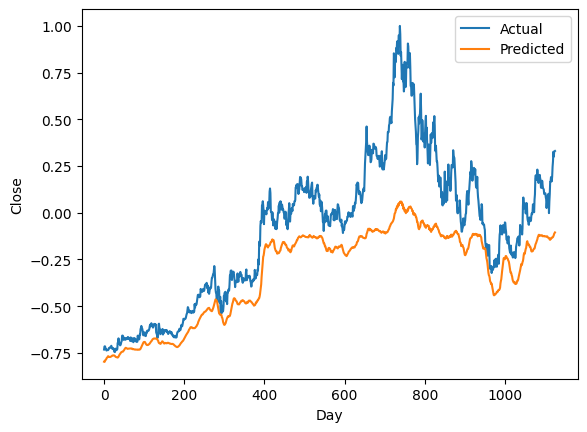

In [116]:
with torch.no_grad():
    model.eval()
    predicted = model(test_dataset.x.reshape(-1, input_size).to(device)).to('cpu').numpy()

plt.plot(test_dataset.y, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [117]:
def descale(data):
    flattened = data.flatten()

    dummies = np.zeros((len(flattened), scaled.shape[1]))
    dummies[:, 0] = flattened
    descaled = scaler.inverse_transform(dummies)[:len(flattened), 0]
    return descaled

In [118]:
descaled_predictions = descale(predicted)
descaled_real = descale(test_dataset.y)

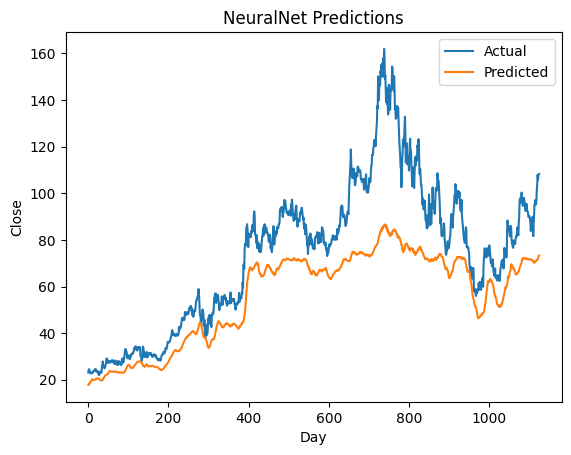

In [125]:
plt.plot(descaled_real, label='Actual')
plt.plot(descaled_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('NeuralNet Predictions')
plt.savefig('./plots/NeuralNet_Predictions.png')
plt.show()

In [120]:
print(f'Explained Variance Score: {explained_variance_score(descaled_real, descaled_predictions):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(descaled_real, descaled_predictions):.4f}')

Explained Variance Score: 0.7962
Mean Absolute Error: 17.9950


In [121]:
print(f'Mean Squared Error: {mean_squared_error(descaled_real, descaled_predictions):.4f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(descaled_real, descaled_predictions):.4f}')

Mean Squared Error: 524.1275
Mean Absolute Percentage Error: 0.2185


In [122]:
print(f'Median Absolute Error: {median_absolute_error(descaled_real, descaled_predictions):.4f}')
print(f'R2 Score: {r2_score(descaled_real, descaled_predictions):.4f}')

Median Absolute Error: 14.0884
R2 Score: 0.4668


In [123]:
print(f'Mean Poisson Deviance: {mean_poisson_deviance(descaled_real, descaled_predictions):.4f}')
print(f'D2 Absolute Error Score: {d2_absolute_error_score(descaled_real, descaled_predictions):.4f}')

Mean Poisson Deviance: 6.3716
D2 Absolute Error Score: 0.2881
